## Dataset

In [6]:

from torch.utils.data import Dataset
import numpy as np
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler


ModuleNotFoundError: No module named 'torch'

In [ ]:

class ClusterData(Dataset):
    def __init__(self, data, seq_len,prediction_len):
        self.seq_len = seq_len
        self.data = data
        self.prediction_len = prediction_len
        self.len = data.shape[0] - seq_len - prediction_len + 1

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len, :]
        label = self.data[idx+self.seq_len:idx+self.seq_len+self.prediction_len, :]
        return torch.tensor(x, dtype=torch.float), torch.tensor(label, dtype=torch.float)
        


In [3]:
dir="Data/fishes/fish02/s1/df_timeseries_red_clusters_s1.csv"
data_vis=pd.read_csv(dir)


,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8
0,-0.465304,-0.039182,-0.145111,-0.820533,-0.043201,0.065635,-0.133898,-1.221447
1,-0.360442,0.565558,-0.029222,-0.730112,0.269952,0.325601,-0.065495,-0.490533
2,-0.204723,0.364503,0.119252,-0.529757,-0.244755,0.430598,0.164129,-0.567888
3,0.062240,0.274655,-0.139845,-0.408598,-0.201634,0.225573,-0.259828,-0.356369
4,-0.331344,0.372020,0.076066,-0.736249,-0.149454,0.482838,-0.297057,-0.240255


In [4]:
def scaler(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled

In [9]:
data = np.genfromtxt(dir, delimiter=',', skip_header=1)

data.shape

(1031, 8)

In [6]:
data = scaler(data)

In [7]:
def normalize(X):
        X = np.transpose(X)
        X_norm = []
        for x in X:
            x = (x-np.min(x)) / (np.max(x)-np.min(x))
            X_norm.append(x)
        return np.transpose(X_norm)

## DataLoader

In [8]:
from torch.utils.data import DataLoader 
cluster_data=ClusterData(data,300,100)


In [14]:
train_dataloader = DataLoader(cluster_data, batch_size=10, shuffle=False)

In [15]:
for batch_idx, (inputs, labels) in enumerate(train_dataloader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Input shape: {inputs.shape}")
    print(f"Label shape: {labels.shape}")
    break



Batch 1:
Input shape: torch.Size([10, 300, 8])
Label shape: torch.Size([10, 100, 8])


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## UTLIS

## Model

In [43]:
import math
import torch


class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor):
        """Adds positional encoding to the given tensor.

        Args:
            x: tensor to add PE to [bs, seq_len, embed_dim]

        Returns:
            torch.Tensor: tensor with PE [bs, seq_len, embed_dim]
        """
        x = x + self.pe[:, : x.size(1)]
        return self.dropout(x)


In [57]:

class CustomTransformerEncoderLayer(torch.nn.TransformerEncoderLayer):
    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        """Pass the input through the encoder layer.

        Args:
            src: the sequence to the encoder layer (required).
            src_mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).

        Shape:
            src: (batch_size, src_len, d_model)
            src_mask: (src_len, src_len)
            src_key_padding_mask: (batch_size, src_len)

        Returns:
            A tuple of the output tensor and the attention weights.
        """
        # Self-attention
        src2, self.attn_weights = self.self_attn(src, src, src, attn_mask=src_mask,
                                             key_padding_mask=src_key_padding_mask,
                                             need_weights=True)
        src = src + self.dropout1(src2)
        src = self.norm1(src)

        # Feed forward
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)

        return src







In [59]:
class CustomTransformerDecoderLayer(torch.nn.TransformerDecoderLayer):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu"):
        super().__init__(d_model, nhead, dim_feedforward, dropout, activation)
        self.self_attn_weights = None
        self.cross_attn_weights = None

    def forward(self, tgt, memory, tgt_mask, memory_mask=None,
                tgt_key_padding_mask=None, memory_key_padding_mask=None, need_weights=True):
        # Self-attention
        tgt2, self.self_attn_weights = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask,
                                                 key_padding_mask=tgt_key_padding_mask,
                                                 need_weights=need_weights)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        
        # Cross-attention
        tgt2, self.cross_attn_weights = self.multihead_attn(tgt, memory, memory, attn_mask=memory_mask,
                                                       key_padding_mask=memory_key_padding_mask,
                                                       need_weights=need_weights)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        
        # Feed forward
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        
        return tgt

In [62]:
class TransformerWithPE(torch.nn.Module):
    def __init__(
        self, in_dim: int, out_dim: int, embed_dim: int, num_heads: int, num_layers: int
    ):
        """Initializes a transformer model with positional encoding.

        Args:
            in_dim: number of input features
            out_dim: number of features to predict
            embed_dim: embed features to this dimension
            num_heads: number of transformer heads
            num_layers: number of encoder and decoder layers
        """
        super().__init__()

        self.positional_encoding = PositionalEncoding(embed_dim)

        self.encoder_embedding = torch.nn.Linear(
            in_features=in_dim, out_features=embed_dim
        )
        self.decoder_embedding = torch.nn.Linear(
            in_features=out_dim, out_features=embed_dim
        )
        self.output_layer = torch.nn.Linear(in_features=embed_dim, out_features=out_dim)
        
        
        self.encoder_layers = CustomTransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = torch.nn.TransformerEncoder(self.encoder_layers, num_layers=num_layers)
        
        self.decoder_layers = CustomTransformerDecoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer_decoder = torch.nn.TransformerDecoder(self.decoder_layers, num_layers=num_layers)
        

    def forward(self, src: torch.Tensor, tgt: torch.Tensor, return_attention_weights=True):
        """Forward function of the model.

        Args:
            src: input sequence to the encoder [bs, src_seq_len, num_features]
            tgt: input sequence to the decoder [bs, tgt_seq_len, num_features]

        Returns:
            torch.Tensor: predicted sequence [bs, tgt_seq_len, feat_dim]
        """
        # if self.train:
        # Add noise to decoder inputs during training
        # tgt = tgt + torch.normal(0, 0.1, size=tgt.shape).to(tgt.device)

        # Embed encoder input and add positional encoding.
        # [bs, src_seq_len, embed_dim]
        src = self.encoder_embedding(src)
        src = self.positional_encoding(src)
        
        encoded_src = self.transformer_encoder(src)

        encoder_attention_weights = [layer.attn_weights for layer in self.transformer_encoder.layers]
        
        tgt = self.decoder_embedding(tgt)
        tgt = self.positional_encoding(tgt)
        # Generate mask to avoid attention to future outputs.
        # [tgt_seq_len, tgt_seq_len]
        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(tgt.size(1)).to(device)
        
        decoded_tgt = self.transformer_decoder(tgt, encoded_src, tgt_mask=tgt_mask)
        self_attn_weights = [layer.self_attn_weights for layer in self.transformer_decoder.layers]
        cross_attn_weights = [layer.cross_attn_weights for layer in self.transformer_decoder.layers]


        # Embed decoder input and add positional encoding.
        # [bs, tgt_seq_len, embed_dim]

        # Get prediction from transformer and map to output dimension.
        # [bs, tgt_seq_len, embed_dim]
        
        pred = self.output_layer(decoded_tgt)
        
        if return_attention_weights:
            return pred, (encoder_attention_weights, self_attn_weights, cross_attn_weights)
        else:
            return pred

        

    def infer(self, src: torch.Tensor, tgt_len: int):
        """Generate predictions for future time steps.
        
        Args:
            src: Input sequence for the encoder [bs, src_seq_len, num_features].
            tgt_len: Number of future time steps to predict.
         
        Returns:
            torch.Tensor: Predicted future values.
        """
        # Initialize the first input for the decoder with the last timestep of src.
        current_input = src[:, -1:, :]  # Take the last timestep, keep dimensions.

        predictions = []

        for _ in range(tgt_len):
            # Predict the next step.
            next_step = self.forward(src, current_input)[:, -1:, :]
            predictions.append(next_step)
            
            # Update current_input with the predicted next step for the next iteration.
            current_input = next_step

        # Concatenate all predicted steps.
        predictions = torch.cat(predictions, dim=1)

        return predictions

In [86]:
class CustomTransformerEncoderLayer(torch.nn.TransformerEncoderLayer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.attn_weights = None

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        """Pass the input through the encoder layer.
        Args:
            src: the sequence to the encoder layer (required).
            src_mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).
        Shape:
            src: (batch_size, src_len, d_model)
            src_mask: (src_len, src_len)
            src_key_padding_mask: (batch_size, src_len)
        Returns:
            The output tensor of the encoder layer.
        """
        # Self-attention
        src2, self.attn_weights = self.self_attn(src, src, src, attn_mask=src_mask,
                                                 key_padding_mask=src_key_padding_mask,
                                                 need_weights=True)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        # Feed forward
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src


class CustomTransformerDecoderLayer(torch.nn.TransformerDecoderLayer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.self_attn_weights = None
        self.cross_attn_weights = None

    def forward(self, tgt, memory, tgt_mask, memory_mask=None,
                tgt_key_padding_mask=None, memory_key_padding_mask=None, need_weights=True):
        # Self-attention
        tgt2, self.self_attn_weights = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask,
                                                      key_padding_mask=tgt_key_padding_mask,
                                                      need_weights=need_weights)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        # Cross-attention
        tgt2, self.cross_attn_weights = self.multihead_attn(tgt, memory, memory, attn_mask=memory_mask,
                                                            key_padding_mask=memory_key_padding_mask,
                                                            need_weights=need_weights)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        # Feed forward
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt


class TransformerWithPE(torch.nn.Module):
    def __init__(self, in_dim: int, out_dim: int, embed_dim: int, num_heads: int, num_layers: int):
        """Initializes a transformer model with positional encoding.
        Args:
            in_dim: number of input features
            out_dim: number of features to predict
            embed_dim: embed features to this dimension
            num_heads: number of transformer heads
            num_layers: number of encoder and decoder layers
        """
        super().__init__()
        self.positional_encoding = PositionalEncoding(embed_dim)
        self.encoder_embedding = torch.nn.Linear(in_features=in_dim, out_features=embed_dim)
        self.decoder_embedding = torch.nn.Linear(in_features=out_dim, out_features=embed_dim)
        self.output_layer = torch.nn.Linear(in_features=embed_dim, out_features=out_dim)
        self.encoder_layers = CustomTransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = torch.nn.TransformerEncoder(self.encoder_layers, num_layers=num_layers)
        self.decoder_layers = CustomTransformerDecoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer_decoder = torch.nn.TransformerDecoder(self.decoder_layers, num_layers=num_layers)

    def forward(self, src: torch.Tensor, tgt: torch.Tensor, return_attention_weights=True):
        """Forward function of the model.
        Args:
            src: input sequence to the encoder [bs, src_seq_len, num_features]
            tgt: input sequence to the decoder [bs, tgt_seq_len, num_features]
        Returns:
            torch.Tensor: predicted sequence [bs, tgt_seq_len, feat_dim]
        """
        # Embed encoder input and add positional encoding.
        # [bs, src_seq_len, embed_dim]
        src = self.encoder_embedding(src)
        src = self.positional_encoding(src)
        encoded_src = self.transformer_encoder(src)
        encoder_attention_weights = [layer.attn_weights for layer in self.transformer_encoder.layers]

        tgt = self.decoder_embedding(tgt)
        tgt = self.positional_encoding(tgt)
        # Generate mask to avoid attention to future outputs.
        # [tgt_seq_len, tgt_seq_len]
        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(tgt.size(1)).to(device)
        print(tgt.shape)
        #tgt_mask = torch.triu(torch.ones(tgt.size(1), tgt.size(1)), diagonal=1).bool().to(device)
        decoded_tgt = self.transformer_decoder(tgt, encoded_src, tgt_mask=tgt_mask)
        self_attn_weights = [layer.self_attn_weights for layer in self.transformer_decoder.layers]
        cross_attn_weights = [layer.cross_attn_weights for layer in self.transformer_decoder.layers]

        # Get prediction from transformer and map to output dimension.
        # [bs, tgt_seq_len, embed_dim]
        pred = self.output_layer(decoded_tgt)

        if return_attention_weights:
            return pred, (encoder_attention_weights, self_attn_weights, cross_attn_weights)
        else:
            return pred

    def infer(self, src: torch.Tensor, tgt_len: int):
        """Generate predictions for future time steps.
        Args:
            src: Input sequence for the encoder [bs, src_seq_len, num_features].
            tgt_len: Number of future time steps to predict.
        Returns:
            torch.Tensor: Predicted future values.
        """
        # Initialize the first input for the decoder with the last timestep of src.
        current_input = src[:, -1:, :]  # Take the last timestep, keep dimensions.
        predictions = []
        for _ in range(tgt_len):
            # Predict the next step.
            next_step = self.forward(src, current_input, return_attention_weights=False)[:, -1:, :]
            predictions.append(next_step)
            # Update current_input with the predicted next step for the next iteration.
            current_input = next_step
        # Concatenate all predicted steps.
        predictions = torch.cat(predictions, dim=1)
        return predictions

In [ ]:

"""class TransformerWithPE(torch.nn.Module):
    def __init__(
        self, in_dim: int, out_dim: int, embed_dim: int, num_heads: int, num_layers: int
    ):
        """Initializes a transformer model with positional encoding.

        Args:
            in_dim: number of input features
            out_dim: number of features to predict
            embed_dim: embed features to this dimension
            num_heads: number of transformer heads
            num_layers: number of encoder and decoder layers
        """
        super().__init__()

        self.positional_encoding = PositionalEncoding(embed_dim)

        self.encoder_embedding = torch.nn.Linear(
            in_features=in_dim, out_features=embed_dim
        )
        self.decoder_embedding = torch.nn.Linear(
            in_features=out_dim, out_features=embed_dim
        )
        

        self.output_layer = torch.nn.Linear(in_features=embed_dim, out_features=out_dim)

        self.transformer = torch.nn.Transformer(
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            d_model=embed_dim,
            batch_first=True,
        )

    def forward(self, src: torch.Tensor, tgt: torch.Tensor):
        """Forward function of the model.

        Args:
            src: input sequence to the encoder [bs, src_seq_len, num_features]
            tgt: input sequence to the decoder [bs, tgt_seq_len, num_features]

        Returns:
            torch.Tensor: predicted sequence [bs, tgt_seq_len, feat_dim]
        """
        # if self.train:
        # Add noise to decoder inputs during training
        # tgt = tgt + torch.normal(0, 0.1, size=tgt.shape).to(tgt.device)

        # Embed encoder input and add positional encoding.
        # [bs, src_seq_len, embed_dim]
        src = self.encoder_embedding(src)
        src = self.positional_encoding(src)

        # Generate mask to avoid attention to future outputs.
        # [tgt_seq_len, tgt_seq_len]
        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(tgt.shape[1]).to(device)
        # Embed decoder input and add positional encoding.
        # [bs, tgt_seq_len, embed_dim]
        tgt = self.decoder_embedding(tgt)
        tgt = self.positional_encoding(tgt)

        # Get prediction from transformer and map to output dimension.
        # [bs, tgt_seq_len, embed_dim]
        pred = self.transformer(src, tgt, tgt_mask=tgt_mask)
        pred = self.output_layer(pred)

        return pred

    def infer(self, src: torch.Tensor, tgt_len: int):
        """Generate predictions for future time steps.
        
        Args:
            src: Input sequence for the encoder [bs, src_seq_len, num_features].
            tgt_len: Number of future time steps to predict.
        
        Returns:
            torch.Tensor: Predicted future values.
        """
        # Initialize the first input for the decoder with the last timestep of src.
        current_input = src[:, -1:, :]  # Take the last timestep, keep dimensions.

        predictions = []

        for _ in range(tgt_len):
            # Predict the next step.
            next_step = self.forward(src, current_input)[:, -1:, :]
            predictions.append(next_step)
            
            # Update current_input with the predicted next step for the next iteration.
            current_input = next_step

        # Concatenate all predicted steps.
        predictions = torch.cat(predictions, dim=1)

        return predictions
"""

## Training and evaluation

In [84]:
import torch

BS = 1
FEATURE_DIM = 32
NUM_HEADS = 2
NUM_EPOCHS = 1
#NUM_VIS_EXAMPLES = 10        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(tgt.shape[1])

NUM_LAYERS = 2
LR = 0.001

SEQ_LENGHT = 200
PRED_LENGTH = 75

In [89]:

from sklearn.model_selection import train_test_split

#split_idx = int(len(data) * 0.9)  # 90% for training



cluster_data_train = ClusterData(data,SEQ_LENGHT,PRED_LENGTH)

train_dataloader = DataLoader(cluster_data_train, batch_size=BS, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, optimizer and loss criterion
model = TransformerWithPE(in_dim=8, out_dim=8, embed_dim=FEATURE_DIM, num_heads=NUM_HEADS, num_layers=NUM_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.MSELoss()

# Train loop
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0
    model.train()  # Ensure the model is in training mode
    for src, tgt in train_dataloader:
        optimizer.zero_grad()
        
        src, tgt = src.to(device), tgt.to(device)
        predictions, atten = model(src,tgt)  # Assuming the last N steps are for prediction
    
        loss = criterion(predictions, tgt)  # Adjust depending on how you've structured your data
        
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(
        f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: "
        f"{(epoch_loss / len(train_dataloader)):.4f}"
    )

    # Evaluate model
   # model.eval()
    

torch.Size([1, 75, 32])


RuntimeError: The shape of the 2D attn_mask is torch.Size([75, 75]), but should be (1, 1).

In [41]:
def rolling_predictions(model, device, data, input_steps=SEQ_LENGHT, predict_steps=PRED_LENGTH):
    model.eval()  # Set the model to evaluation mode
    predictions = []  # To store all predictions
    prediction_indices = []  # To store the start index of each prediction window

    with torch.no_grad():
        start_idx = 0
        while start_idx + input_steps + predict_steps <= len(data):
            src = data[start_idx:start_idx+input_steps, :].unsqueeze(0)  # Add batch dimension
            src = src.to(device)

            # Predict next steps
            current_pred,*_ = model.infer(src, tgt_len=predict_steps)
            
            # Store predictions and their starting indices
            predictions.append(current_pred.squeeze(0).cpu().numpy())  # Remove batch dimension
            prediction_indices.append(start_idx + input_steps)
            
            # Move the window
            start_idx += predict_steps

    return np.concatenate(predictions, axis=0), prediction_indices



In [20]:
full_data_tensor = torch.tensor(data, dtype=torch.float)
rolling_preds, pred_indices = rolling_predictions(model, device, full_data_tensor)


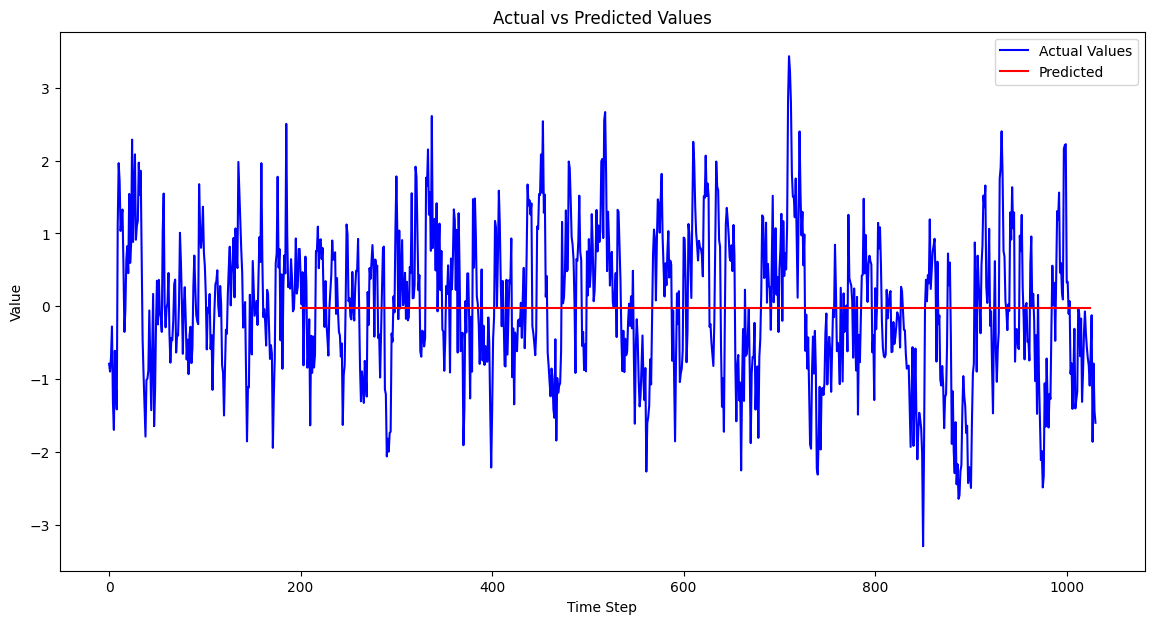

In [22]:
import matplotlib.pyplot as plt

CLUSTER_NUMN = 2

# Actual values
plt.figure(figsize=(14, 7))
plt.plot(data[:, CLUSTER_NUMN], label='Actual Values', color='blue')  # Adjust the index for different series

# Overlay predictions
for start, pred in zip(pred_indices, np.array_split(rolling_preds[:, CLUSTER_NUMN], len(pred_indices))):
    plt.plot(range(start, start + len(pred)), pred, color='red', label='Predicted' if start == pred_indices[0] else "")

plt.title('Actual vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

